In [1]:
# import dependencies 
import numpy as np
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import os
%matplotlib inline 

# Load Data

In [2]:
# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/data_for_model"

In [3]:
# function to load data 
def load_appeals_data(root_path=DATAFOLDER):
    csv_path = os.path.join(root_path, "data_for_model_2018-03-23.csv")
    df = pd.read_csv(csv_path)
    return df 

In [4]:
# load data 
df = load_appeals_data(root_path=DATAFOLDER)
df.set_index('idnAppeal', inplace=True) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253850 entries, 4657002 to 5021568
Data columns (total 15 columns):
nat_string             253688 non-null object
strCustody             212251 non-null object
strProbono             578 non-null object
case_type_string       253848 non-null object
ij_code                253850 non-null object
lawyer                 253850 non-null int64
defensive              248004 non-null float64
affirmative            248004 non-null float64
oral                   253354 non-null float64
written                253354 non-null float64
comp_year              253850 non-null int64
osc_year               253850 non-null float64
input_year             253839 non-null float64
datAppealFiled_year    253850 non-null float64
granted                253850 non-null int64
dtypes: float64(7), int64(3), object(5)
memory usage: 31.0+ MB


# Data Pipelines

In [5]:
# impute missing data

def impute_columns_udf(col, imputation_type): 
    """ 
    UDF to specify imputation method for a given variable. 
    col is the pd.Series for which you want to impute, imputation_type should be chosen from 
    ['mode', 'mean', 'zero', 'none'] 
    """ 
    if imputation_type == 'mode':
        val = col.mode()[0]
        return col.fillna(val)
    
    elif imputation_type == 'mean': 
        val = col.mean() 
        return col.fillna(val)
    
    elif imputation_type == 'zero': 
        return col.fillna(0)
    
    elif imputation_type == 'none':
        return col.fillna('None')
    
    else: 
        raise ValueError('imputation_type argument not valid')

class ImputeMissingData(BaseEstimator, TransformerMixin):
    """ Pipeline step that impute missing values, given impute methods specified. 
        Note that numerical features with NaN's and no impute methods will raise an error, 
        categorical features on the other hand will be filled with 'None' by default unless specified otherwise.
    """
    def __init__(self, impute_methods, num_features, cat_features): 
        self.impute_methods = impute_methods
        self.num_features = num_features
        self.cat_features = cat_features
    
    def fit(self, X, y=None): 
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 

        # check which features have missing values but imputation methods not specified 
        features_nulls = output_data.isnull().sum() 
        features_nulls = features_nulls[features_nulls > 0].index.tolist() 
        features_need_impute = [f for f in features_nulls if f not in self.impute_methods.keys()]
        num_features_need_impute = [f for f in features_need_impute if f in self.num_features]
        cat_features_need_impute = [f for f in features_need_impute if f in self.cat_features]
        
        # raise exception for numerical features with missing values and no imputation method specified 
        if num_features_need_impute: 
            raise Exception("""These numerical features have missing values: {}. 
            Please specify their impute methods.""".format(num_features_need_impute)) 
        
        # set imputation method as 'none' for cat features with missing values with no imputation method specified 
        if cat_features_need_impute: 
            for cat_f in cat_features_need_impute: 
                self.impute_methods[cat_f] = 'none'
            print("""{} have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.""".format(cat_features_need_impute)) 
                
        # apply imputations 
        for col, imp_method in self.impute_methods.items(): 
            output_data[col] = impute_columns_udf(output_data[col], imp_method)
            
        return output_data 

In [6]:
# convert data types
class ConvertDataTypes(BaseEstimator, TransformerMixin): 
    """ Coerce data types to specifications defined by CAT_FEATURES and NUM_FEATURES """
    def __init__(self, num_features, cat_features): 
        self.num_features = num_features 
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, input_data): 
        output_data = input_data.copy() 
        output_data[self.num_features] = output_data[self.num_features].astype(float)
        output_data[self.cat_features] = output_data[self.cat_features].astype(str)
        return output_data 

In [41]:
# dummify data 

class Dummify(BaseEstimator, TransformerMixin): 
    """ Pipeline step that dummifies all categorical variables """
    def __init__(self, cat_feature_values): 
        self.cat_feature_values = cat_feature_values
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, input_data):
        output_data = input_data.copy()
        # specify values categorical features can take on, to ensure train/test DF have same cols 
        cat_features = self.cat_feature_values.keys()
        for col in cat_features: 
            output_data[col] = pd.Categorical(output_data[col], categories=self.cat_feature_values[col])        
        output_data = pd.get_dummies(output_data, columns=cat_features, prefix_sep=':::')
        return output_data

# Model Methods

In [8]:
# method to subset data for training model 
def get_model_data(df, label, cat_features, num_features, impute_methods): 
    """ Subsets variables used for model, runs it through pipeline to output data for model """
    
    # subsets features we are interested in 
    cat_feature_values = dict([(f, df[f].dropna().unique().tolist()) for f in cat_features]) # do EDA and limit to smaller list 
    data = df[cat_features + num_features + [label]].copy() 
    
    # train test split 
    X, y = data.drop(label, axis=1).copy(), data[label].copy() 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # make pipeline 
    data_pipeline = Pipeline([
        ('impute', ImputeMissingData(impute_methods, num_features, cat_features)),         
        ('convert_dtypes', ConvertDataTypes(num_features, cat_features)), 
        ('dummify', Dummify(cat_feature_values))
    ])
    
    # run pipeline 
    X_train = data_pipeline.fit_transform(x_train)
    X_test = data_pipeline.transform(x_test)
    print("Training Data: {} | Test Data: {}".format(X_train.shape, X_test.shape)) 
    
    return X_train, X_test, y_train, y_test 

In [9]:
# method to output evaluation metrics and plot ROC curve 

def evaluate_model(truth, pred, plot_auc): 
    """ Takes in arrays of truth and pred y values and return accuracy, logloss, roc_auc, and plot ROC """ 
    accuracy = accuracy_score(truth, (pred>0.5).astype(int))
    logloss = log_loss(truth, pred)
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    metrics = {'Accuracy': accuracy, 'ROC AUC': roc_auc, 'Log Loss': logloss}
    if plot_auc: 
        plt.plot(fpr, tpr, label= 'AUC = {0:.3f}'.format(roc_auc)) 
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.legend(loc="lower right")
    else: pass 
    return metrics 

In [15]:
# method to train a model, output results, and plot AUC 

def train_model(model, plot_auc=True, print_metrics=True): 
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict_proba(X_test)[:,1]
    metrics = evaluate_model(y_test.values.ravel(), y_pred, plot_auc)
    if print_metrics: 
        print metrics 
    return model, metrics 

# Test Different Variables 

#### One Variable  

Training Data: (203080, 218) | Test Data: (50770, 218)
{'Log Loss': 0.5853393954768995, 'ROC AUC': 0.6623644360447547, 'Accuracy': 0.69334252511325589}


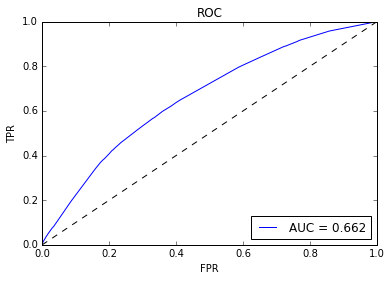

In [21]:
# nationality only 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 422) | Test Data: (50770, 422)
{'Log Loss': 0.5983293739530241, 'ROC AUC': 0.62669774393826994, 'Accuracy': 0.69040772109513493}


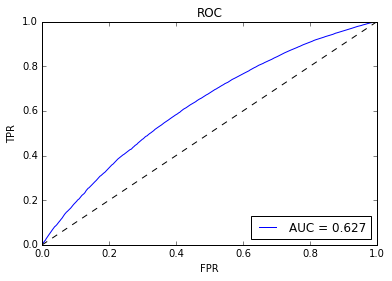

In [22]:
# judge only 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 1) | Test Data: (50770, 1)
{'Log Loss': 0.6092270840465136, 'ROC AUC': 0.58421742872353233, 'Accuracy': 0.69052590112271028}


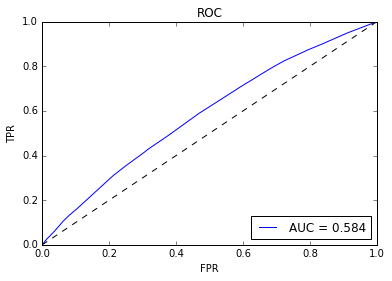

In [23]:
# appeal year only
CAT_FEATURES = []
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Two Variables 

Training Data: (203080, 640) | Test Data: (50770, 640)
{'Log Loss': 0.85104430667397435, 'ROC AUC': 0.69865356060093564, 'Accuracy': 0.71288162300571201}


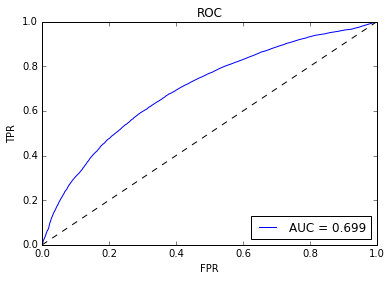

In [24]:
# nationality + judge 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 219) | Test Data: (50770, 219)
{'Log Loss': 0.60162880847940703, 'ROC AUC': 0.72426927117404194, 'Accuracy': 0.73269647429584395}


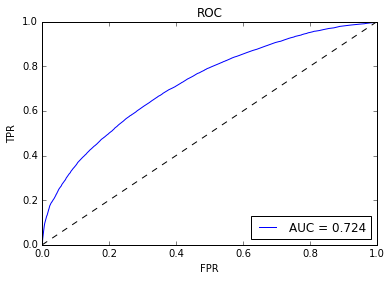

In [25]:
# nationality + appeal year 
CAT_FEATURES = ['nat_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 423) | Test Data: (50770, 423)
{'Log Loss': 0.64653412340535987, 'ROC AUC': 0.6743846275717359, 'Accuracy': 0.70275753397675789}


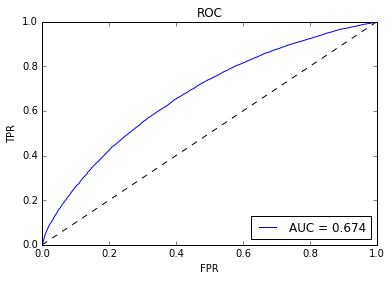

In [26]:
# judge + appeal year 
CAT_FEATURES = ['ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

#### Multiple Variables  

Training Data: (203080, 641) | Test Data: (50770, 641)
{'Log Loss': 1.4266248933175403, 'ROC AUC': 0.75283281975974548, 'Accuracy': 0.7480204845381131}


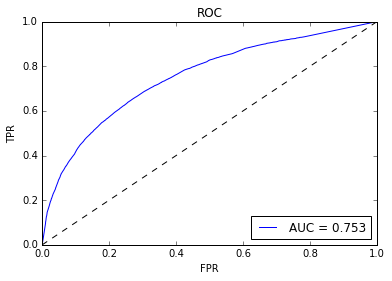

In [27]:
# nationality + judge + appeal year 
CAT_FEATURES = ['nat_string', 'ij_code']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 646) | Test Data: (50770, 646)
{'Log Loss': 1.4605113632891873, 'ROC AUC': 0.75962785488448192, 'Accuracy': 0.75148709868032304}


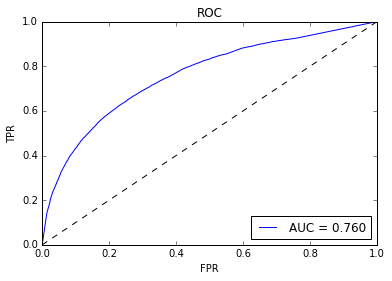

In [28]:
# nationality + judge + appeal year + case type 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'case_type_string': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 650) | Test Data: (50770, 650)
{'Log Loss': 1.5204082216210542, 'ROC AUC': 0.76500365454167485, 'Accuracy': 0.75387039590309235}


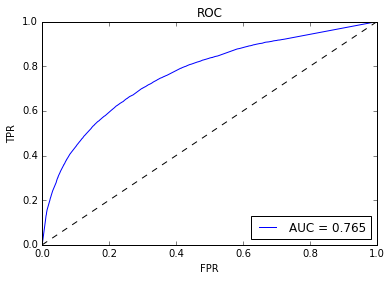

In [29]:
# nationality + judge + appeal year + case type + custody + probono
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none'}  
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 655) | Test Data: (50770, 655)
{'Log Loss': 1.4517462719985745, 'ROC AUC': 0.77320921286748912, 'Accuracy': 0.76054756746109908}


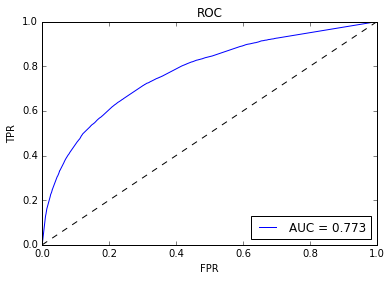

In [30]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 658) | Test Data: (50770, 658)
{'Log Loss': 1.3334179815737204, 'ROC AUC': 0.7971307778498814, 'Accuracy': 0.77443372070120153}


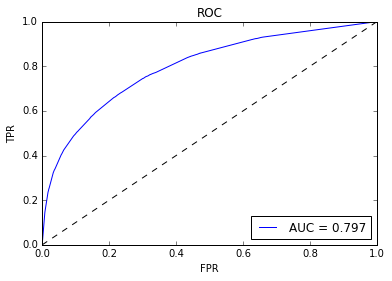

In [31]:
# nationality + judge + appeal year + case type + custody + probono + lawyer + defensive/affirmative, oral/written 
# + comp/osc/input years 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

Training Data: (203080, 658) | Test Data: (50770, 658)
{'Log Loss': 0.63365743280407694, 'ROC AUC': 0.81729959031873789, 'Accuracy': 0.78540476659444558}


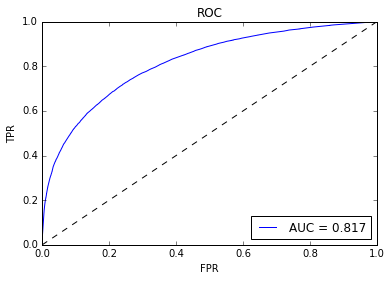

In [32]:
# same as above but more trees 
CAT_FEATURES = ['nat_string', 'ij_code', 'case_type_string', 'strCustody', 'strProbono']
NUM_FEATURES = ['datAppealFiled_year', 'lawyer', 'defensive', 'affirmative', 'oral', 'written',
                'comp_year', 'osc_year', 'input_year']
IMPUTE_METHODS = {'nat_string': 'none', 'strCustody': 'none', 'strProbono': 'none', 'case_type_string': 'none', 
                  'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 'written': 'zero', 'input_year': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=100))

X_train, X_test, y_train, y_test = get_model_data(df, label='granted', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
model, metrics = train_model(model=MODEL, plot_auc=True, print_metrics=True)

# Feature Importance 

In [39]:
feature_importances = pd.Series(data=model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.head(20)

datAppealFiled_year             0.128928
comp_year                       0.082173
osc_year                        0.074954
input_year                      0.070979
nat_string_EL SALVADOR          0.026380
nat_string_HAITI                0.017053
lawyer                          0.013002
strCustody_N                    0.010078
nat_string_CHINA                0.009393
case_type_string_DEPORTATION    0.009294
nat_string_GUATEMALA            0.009173
nat_string_NICARAGUA            0.008494
strCustody_R                    0.007572
strCustody_D                    0.006845
affirmative                     0.006816
defensive                       0.006604
oral                            0.006165
nat_string_IRAQ                 0.005839
nat_string_INDIA                0.005433
written                         0.005098
dtype: float64

In [40]:
#TODO: Group dummy variables that are not well-represented in dataset 
feature_importances.tail(20)

nat_string_SAMOA                             1.011187e-06
ij_code_CAH                                  9.609247e-07
ij_code_TRE                                  9.293027e-07
nat_string_NAURU                             8.542142e-07
nat_string_KIRIBATI                          8.333265e-07
nat_string_ARUBA                             6.827106e-07
nat_string_FAEROE ISLAND                     6.379077e-07
nat_string_MALDIVES                          6.038388e-07
nat_string_SWAZILAND                         6.019688e-07
nat_string_BRITISH INDIAN OCEAN TERRITORY    4.728725e-07
nat_string_MARTINIQUE                        4.229069e-07
nat_string_PEOPLE'S REPUBLIC OF BENIN        3.413498e-07
ij_code_EHM                                  3.227307e-07
ij_code_JCO                                  1.196898e-07
nat_string_BRITISH VIRGIN ISLANDS            4.400999e-08
nat_string_BRITISH WEST INDIES               0.000000e+00
ij_code_SMN                                  0.000000e+00
ij_code_HJA   

In [ ]:
# Collapse feature importances for dummy variables onto their respective parent 
def collapse_feature_importances(feature_importances, list_of_cat_variables): 
    """ Takes a pd.series representing feature importances of variables including dummies, 
        and a list of parent 
    """